    Year           GDP  gdpGrowth  Inflation  Unemployment  Refugees  Water
0   2000  8.460790e+09   4.245712   0.666881        13.700         0  0.937
1   2001  8.975815e+09   5.269958   1.772204        14.700         0  0.937
2   2002  9.582511e+09   5.783808   1.832994        15.300         5  0.937
3   2003  1.019563e+10   4.161668   1.630000        14.500        28  0.937
4   2004  1.141171e+10   8.567214   3.361868        14.628        37  0.937
5   2005  1.258900e+10   8.146595   3.493685        14.800        40  0.937
6   2006  1.505698e+10   8.092975   6.251725        14.000        42  0.937
7   2007  1.711044e+10   8.176170   4.743906        13.100        41  0.937
8   2008  2.265872e+10   7.220386  13.971231        12.700        44  0.937
9   2009  2.453788e+10   5.023710  -0.739070        12.900       138  0.937
10  2010  2.713380e+10   2.314834   4.845519        12.500       198  0.937
11  2011  2.952415e+10   2.737180   4.162442        12.900       193  0.937
12  2012  3.

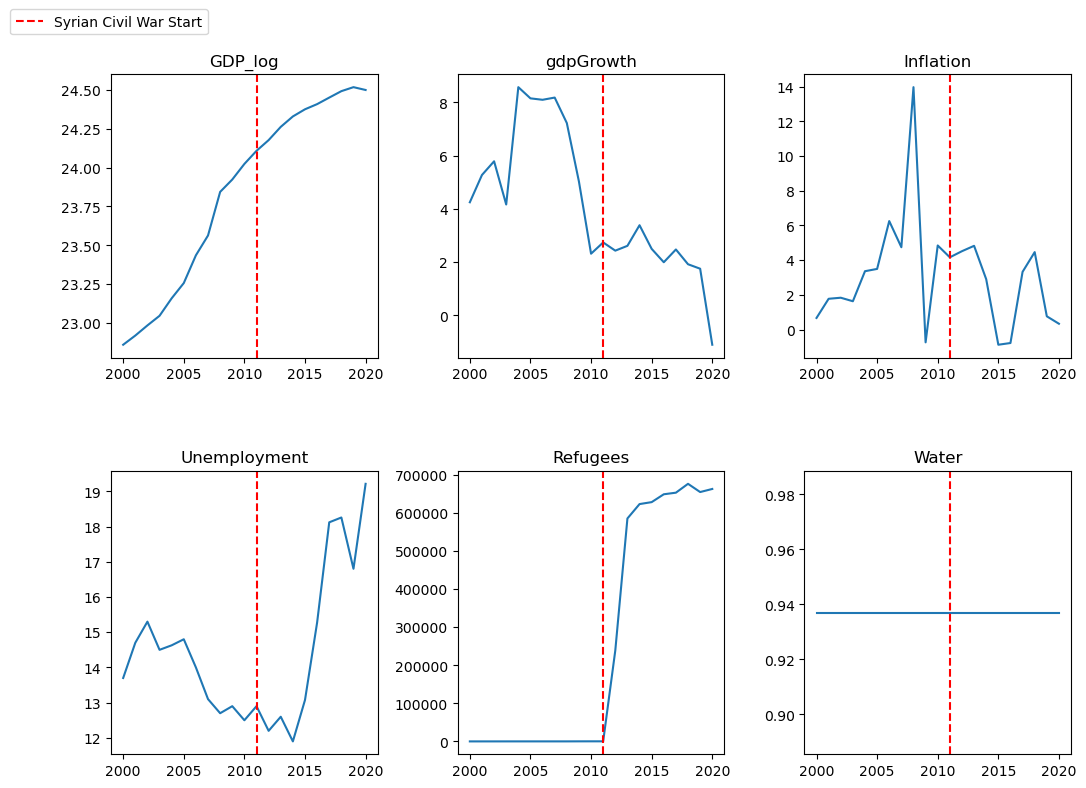

In [5]:
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
from functools import reduce
import numpy as np

print("--- 최신 버전 코드 실행 확인 ---")
# Data Management
project_root = Path.cwd()

def get_data_path(dataname):
    data_path = project_root / 'data' / dataname
    return data_path

def get_Jordan_row(dataname, skiprow, start, end):
    get_data_path(dataname)
    tmp = pd.read_csv(get_data_path(dataname), skiprows = skiprow, sep = ',')
    tmp = tmp[tmp['Country Name'] == 'Jordan']
    tmp = tmp.loc[:, start:end].copy()
    return tmp

def transform_data(df_wide, col_name):
    df_long = df_wide.T
    df_long = df_long.reset_index()
    df_long.columns = ['Year', col_name]
    df_long['Year'] = df_long['Year'].astype(int)
    return df_long

# Jordan Refugees from Syria data
Jordan_Refugees_org = pd.read_csv(get_data_path('WorldBank_Jordan_Refugees.csv'))
Jordan_Refugees = Jordan_Refugees_org.loc[:, ['Year', 'Refugees']].copy()

# Jordan Total Water Resource data
Jordan_Water_org = pd.read_csv(get_data_path('WorldBank_totalWater.csv'))
Jordan_Water = Jordan_Water_org[Jordan_Water_org['REF_AREA_LABEL'] == 'Jordan']
Jordan_Water = Jordan_Water.iloc[0].fillna(Jordan_Water.iloc[1])
Jordan_Water = Jordan_Water.to_frame(name = 'Water')
Jordan_Water = Jordan_Water.reset_index()
Jordan_Water.columns = ['Year', 'Water']
Jordan_Water = Jordan_Water.set_index('Year')
Jordan_Water = Jordan_Water.loc['2000':'2020']
Jordan_Water.reset_index(inplace = True)
Jordan_Water['Year'] = Jordan_Water['Year'].astype(int)

data_dictionary = {
    'WorldBank_GDP.csv' : 'GDP',
    'WorldBank_gdpGrowth.csv' : 'gdpGrowth',
    'WorldBank_Inflation.csv' : 'Inflation',
    'WorldBank_Unemployment.csv' : 'Unemployment',
}

merge_data = []
for filename, col_name in data_dictionary.items():
    Jordan_wide = get_Jordan_row(filename, 4, '2000', '2020')
    Jordan_long = transform_data(Jordan_wide, col_name)
    merge_data.append(Jordan_long)

merge_data.append(Jordan_Refugees)
merge_data.append(Jordan_Water)

Jordan_indexes = reduce(lambda left, right: pd.merge(left, right, on = 'Year', how = 'outer'), merge_data)

print(Jordan_indexes)

# Visualizing

Jordan_indexes['GDP'] = np.log(Jordan_indexes['GDP'])
Jordan_indexes = Jordan_indexes.rename(columns={'GDP' : 'GDP_log'})
Jordan_long = pd.melt(Jordan_indexes, id_vars = ['Year'], var_name = 'indicator', value_name = 'value')
indicator_list = Jordan_long['indicator'].unique()

fig, axs = plt.subplots(nrows = 2,ncols = 3, figsize = (12, 8))
for ax, indicator in zip(axs.flatten(), indicator_list):
    plot_data = Jordan_long[Jordan_long['indicator'] == indicator]
    ax.plot(plot_data['Year'], plot_data['value'])
    ax.set_title(indicator)
    ax.axvline(x=2011, color='red', linestyle='--', linewidth=1.5, label='Syrian Civil War Start')

handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.01, 0.99))
fig.subplots_adjust(
    left=0.1,      # 왼쪽 여백
    right=0.9,     # 오른쪽 여백
    top=0.9,      # 위쪽 여백 (suptitle과의 간격 확보)
    bottom=0.05,   # 아래쪽 여백
    wspace=0.3,    # 서브플롯 좌우 간격
    hspace=0.4     # 서브플롯 상하 간격
)

plt.savefig('Jordan_indexes.png')
plt.show()